基于显微图像的PyTorch+CNN自动细胞计数方法

"""

训练数据集: BBBC005 (包含从显微镜图像中分割的细胞核)

数据来源: BBBC (Broad Bioimage Benchmark Collection)

URL: BBBC (https://bbbc.broadinstitute.org/BBBC005)

Introduction: 

    Images：
        Simulated HCS images were generated with the SIMCEP simulating platform for fluorescent cell population images (Lehmussola et al., IEEE T. Med. Imaging, 2007 and Lehmussola et al., P. IEEE, 2008). These images were simulated for a given cell count with a clustering probability of 25% and a CCD noise variance of 0.0001. Focus blur was simulated by applying Gaussian filters to the images. Each image is 696 x 520 pixels in 8-bit TIF format, with the nuclei and cell areas were matched to the average nuclei and cell areas from the BBBC006 (Human U2OS cells (out of focus)) image set.

    The image nomenclature was chosen to permit metadata to be organized in a plate layout. Each image follows the form

        SIMCEPImages_well_Ccells_Fblur;_ssamples_wstain.TIF

    where the variables are as follows:

        well: The standard 384-well plate format is used where the rows are named A-P and the columns 1- 24.

        cells: The number of cells simulated in the image (1-100).

        blur: The amount of focus blur applied (1-48). The focus blur was simulated by using MATLAB's imfilter function with a rotationally symmetric Gaussian lowpass filter of diameter  and sigma of 0.25 × 

        sample: Number of samples (1-25) for a given combination of  and . Can be used to mimic the "site" number for each well.

        stain: 1 = cell body stain, 2 = nuclei stain.

        The result of this plate nomenclature is that "row" represents a given amount of blur and the "columns" are a given cell count.

    There are 19,200 image files.

"""

In [1]:
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# 检查是否可以使用 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# 从文件名中提取标签
"""
    函数名: parse_label_from_filename.
    函数功能: 从文件名中提取细胞数量(cells)和模糊程度(blur)的标签.
    例如, 对于文件名 SIMCEPImages_1_1;_1_1.TIF, cells=1.
"""
def parse_label_from_filename(filename):
    match = re.search(r"C(\d+)", filename)
    if match:
        return int(match.group(1))  # 返回细胞数量
    else:
        raise ValueError(f"无法从文件名 '{filename}' 中提取细胞数量！")


In [4]:
# 测试 parse_label_from_filename 函数
filename = "SIMCEPImages_A01_C1_F1_s01_w1.TIF"
print(parse_label_from_filename(filename))

1


In [5]:
# 创建数据集的类
class CellCountingDataset(Dataset):
    def __init__(self, image_dir, file_list, transform=None):
        self.image_dir = image_dir
        self.file_list = file_list
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("L")  # 转为灰度图
        label = parse_label_from_filename(img_name)  # 从文件名提取标签
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.float32)

In [6]:
# 数据预处理

# 数据增强
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((520, 696), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.Resize((520, 696)),
    transforms.ToTensor(),
])

# 数据集划分
def prepare_datasets(image_dir, test_size=0.2, random_state=42):
    
    # 获取所有文件名
    all_files = [f for f in os.listdir(image_dir) if f.endswith(".TIF")]
    
    # 按 80:10:10 划分数据集
    train_files, val_test_files = train_test_split(all_files, test_size=test_size, random_state=random_state)
    val_files, test_files = train_test_split(val_test_files, test_size=0.5, random_state=random_state)
    
    # 创建数据集
    train_dataset = CellCountingDataset(image_dir, train_files, transform=train_transform)
    val_dataset = CellCountingDataset(image_dir, val_files, transform=val_test_transform)
    test_dataset = CellCountingDataset(image_dir, test_files, transform=val_test_transform)
    
    return train_dataset, val_dataset, test_dataset


In [7]:
# 定义卷积神经网络
class CellCountingCNN(nn.Module):
    def __init__(self):
        super(CellCountingCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 65 * 87, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # 输出一个细胞数量
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [8]:
# 训练函数
def train_model(model, train_loader, val_loader, epochs, criterion, optimizer, device, model_path, batch_size, learning_rate):
    model.to(device)
    
    # 用于记录损失
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # 计算训练集平均损失
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()
        
        # 计算验证集平均损失
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        #每隔5个epoch保存一次模型
        if((epoch+1)%5==0) :
            torch.save(model.state_dict(), f"D:\MechineLearning_Project\AutoCellCounting\model\model_{batch_size}_{epoch}_{learning_rate}.pth")
            print(f"Model saved to {model_path}")

    # 保存参数权值模型
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")
    
    # 可视化训练和验证损失
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_losses, label="Training Loss", marker="o")
    plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Training and Validation Loss(batch_size: {batch_size}, learning_rate: {learning_rate}")
    plt.legend()
    plt.grid(True)
    plt.show()


<>:44: SyntaxWarning: invalid escape sequence '\M'
<>:44: SyntaxWarning: invalid escape sequence '\M'
C:\Users\KITAYIKUYO\AppData\Local\Temp\ipykernel_1600\3415329758.py:44: SyntaxWarning: invalid escape sequence '\M'
  torch.save(model.state_dict(), f"D:\MechineLearning_Project\AutoCellCounting\model\model_{batch_size}_{epoch}_{learning_rate}.pth")


In [9]:
#训练准备

# 参数
image_dir = "D:\MechineLearning_Project\AutoCellCounting\database\BBBC005_v1_images\BBBC005_v1_images"
batch_size = 32
epochs = 200
learning_rate = 0.001
model_path = f"D:\MechineLearning_Project\AutoCellCounting\model\model_{batch_size}_{epochs}_{learning_rate}.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 载入数据集
train_dataset, val_dataset, test_dataset = prepare_datasets(image_dir)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 模型初始化
model = CellCountingCNN()
criterion = nn.MSELoss()  # 使用均方误差作为损失函数
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

<>:4: SyntaxWarning: invalid escape sequence '\M'
<>:8: SyntaxWarning: invalid escape sequence '\M'
<>:4: SyntaxWarning: invalid escape sequence '\M'
<>:8: SyntaxWarning: invalid escape sequence '\M'
C:\Users\KITAYIKUYO\AppData\Local\Temp\ipykernel_1600\1341793745.py:4: SyntaxWarning: invalid escape sequence '\M'
  image_dir = "D:\MechineLearning_Project\AutoCellCounting\database\BBBC005_v1_images\BBBC005_v1_images"
C:\Users\KITAYIKUYO\AppData\Local\Temp\ipykernel_1600\1341793745.py:8: SyntaxWarning: invalid escape sequence '\M'
  model_path = f"D:\MechineLearning_Project\AutoCellCounting\model\model_{batch_size}_{epochs}_{learning_rate}.pth"


Epoch [1/200], Train Loss: 331.0331, Val Loss: 234.6482
Epoch [2/200], Train Loss: 182.9385, Val Loss: 190.8701
Epoch [3/200], Train Loss: 149.9451, Val Loss: 138.4631
Epoch [4/200], Train Loss: 130.6175, Val Loss: 118.4526
Epoch [5/200], Train Loss: 119.9631, Val Loss: 129.0074
Model saved to D:\MechineLearning_Project\AutoCellCounting\model\model_32_200_0.001.pth
Epoch [6/200], Train Loss: 110.5114, Val Loss: 132.2523
Epoch [7/200], Train Loss: 108.7941, Val Loss: 102.8716
Epoch [8/200], Train Loss: 106.1507, Val Loss: 102.1821
Epoch [9/200], Train Loss: 101.0800, Val Loss: 99.9014
Epoch [10/200], Train Loss: 99.7779, Val Loss: 96.9036
Model saved to D:\MechineLearning_Project\AutoCellCounting\model\model_32_200_0.001.pth
Epoch [11/200], Train Loss: 98.7202, Val Loss: 97.5185
Epoch [12/200], Train Loss: 91.5569, Val Loss: 143.9450
Epoch [13/200], Train Loss: 92.7538, Val Loss: 92.8906
Epoch [14/200], Train Loss: 91.1713, Val Loss: 93.0107
Epoch [15/200], Train Loss: 87.4102, Val Loss

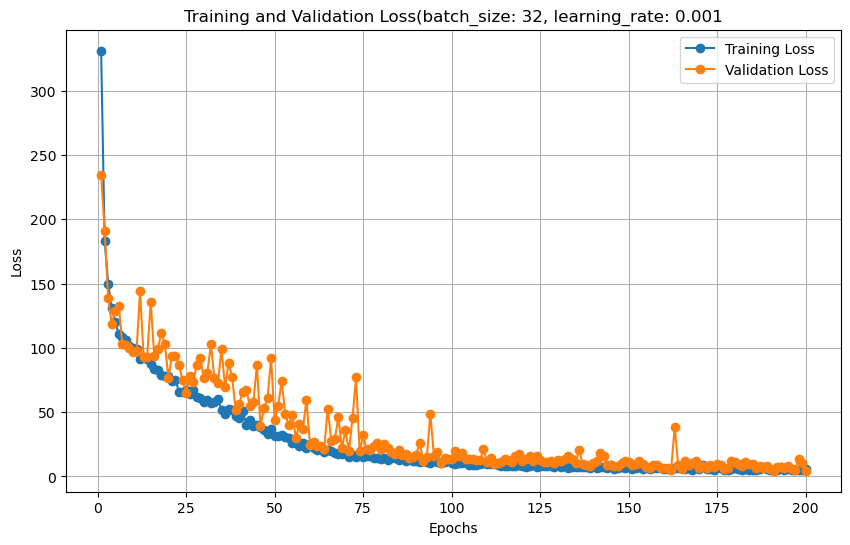

In [16]:
# 训练模型并保存
train_model(model, train_loader, val_loader, epochs, criterion, optimizer, device, model_path, batch_size, learning_rate)

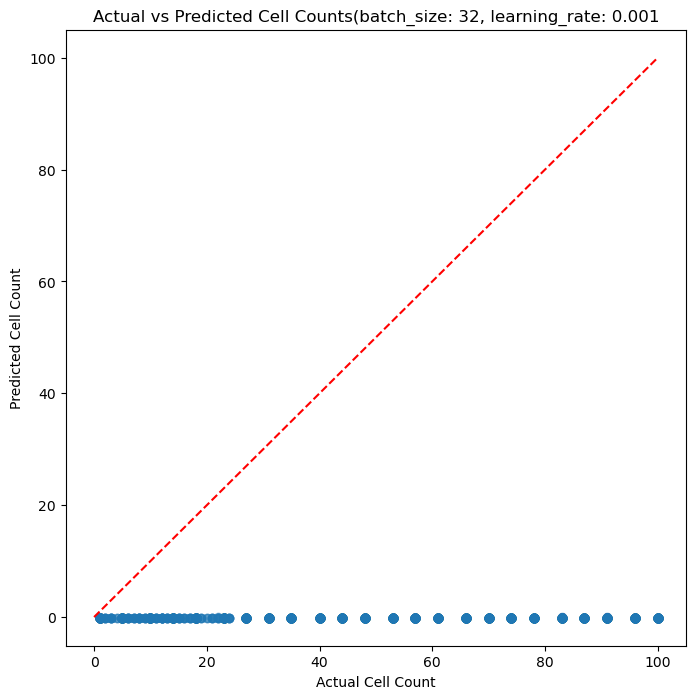

In [10]:
# 可视化预测值和实际值
def visualize_predictions(model, test_loader, device):
    model.eval()
    model.to(device)
    predictions, labels = [], []
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            outputs = model(images).squeeze().cpu().numpy()
            predictions.extend(outputs)
            labels.extend(targets.numpy())
    
    # 绘制散点图
    plt.figure(figsize=(8, 8))
    plt.scatter(labels, predictions, alpha=0.5)
    plt.plot([0, 100], [0, 100], '--', color='red')  # y=x 的参考线
    plt.xlabel("Actual Cell Count")
    plt.ylabel("Predicted Cell Count")
    plt.title(f"Actual vs Predicted Cell Counts(batch_size: {batch_size}, learning_rate: {learning_rate}")
    plt.show()
# 测试模型并可视化
visualize_predictions(model, test_loader, device)